# Поиск по изображениям

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

Данные лежат в папке `/datasets/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорт модулей

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import re
import spacy

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from matplotlib import pyplot as plt

import transformers
from transformers import BertTokenizer

from sklearn.decomposition import PCA
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

from joblib import dump, load


## Константы

In [2]:
KEYWORDS = ["young", "child", "baby", "little", "girl", "boy"]
TRAIN_IMAGES = "./datasets/train_images/"
TEST_IMAGES = "./datasets/test_images/"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 123
SCORE = "f1"
SCORE_REG = "neg_root_mean_squared_error"
NUM_IMGS = 3


## 1. Исследовательский анализ данных

Загрузим датасет с экспертными оценками. Получим агрегированную оценку экспертов, для этого посчитаем суммарную оценку (она может изменяться от 3 до 12) и нормируем ее к единице, для этого вычтем минимальное значение и поделим на максимальное значение в столбце.

In [3]:
df_expert_ann = pd.read_csv("./datasets/ExpertAnnotations.tsv", sep="\t", header=None)
df_expert_ann.set_axis(["image", "query_id", "exp_1", "exp_2", "exp_3"], axis="columns", inplace=True)

df_expert_ann["exp_agg"] = df_expert_ann[["exp_1", "exp_2", "exp_3"]].apply(sum, axis=1)
df_expert_ann["exp_agg"] = round((df_expert_ann["exp_agg"] - df_expert_ann["exp_agg"].min()) /
                                 (df_expert_ann["exp_agg"].max() - df_expert_ann["exp_agg"].min()), 2)

def df_annotation(df, annotation):
    print(annotation)
    print(f"Размер датасета: {df.shape} \n"
          f"Количество пропусков: {df.isna().sum().sum()} \n"
          f"Количество дубликатов: {df.duplicated().sum()}")

display(df_expert_ann.head())
df_annotation(df_expert_ann, "df_expert_ann")
print(f"Диапазон exp_agg: {df_expert_ann['exp_agg'].min()} - {df_expert_ann['exp_agg'].max()}")


image                     query_id  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1   

   exp_3  exp_agg  
0      1     0.00  
1      2     0.11  
2      2     0.11  
3      2     0.22  
4      2     0.11

df_expert_ann
Размер датасета: (5822, 6) 
Количество пропусков: 0 
Количество дубликатов: 0
Диапазон exp_agg: 0.0 - 1.0


Загрузим датасет с краудсорсинговыми оценками.

In [4]:
df_crowd_ann = pd.read_csv("./datasets/CrowdAnnotations.tsv", sep="\t", header=None)
df_crowd_ann.set_axis(["image", "query_id", "ratio", "num_yes", "num_no"], axis="columns", inplace=True)
df_crowd_ann["ratio"] = df_crowd_ann["ratio"].round(2)

display(df_crowd_ann.head())
df_annotation(df_crowd_ann, "df_crowd_ann")
print(f"Диапазон ratio: {df_crowd_ann['ratio'].min()} - {df_crowd_ann['ratio'].max()}")


image                     query_id  ratio  num_yes  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.0        3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2    0.0        0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2    0.0        0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2    0.0        0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2    0.0        0   

   num_no  
0       0  
1       3  
2       3  
3       3  
4       3

df_crowd_ann
Размер датасета: (47830, 5) 
Количество пропусков: 0 
Количество дубликатов: 0
Диапазон ratio: 0.0 - 1.0


Соединим два датасета в один по полям `image` и `query_id`.

In [5]:
df_img_query_grade = df_expert_ann.merge(df_crowd_ann, on=["image", "query_id"], how="outer")
df_img_query_grade.drop(columns=["exp_1", "exp_2", "exp_3", "num_yes", "num_no"], inplace=True)
df_img_query_grade.fillna(-1, inplace=True)

display(df_img_query_grade.head())
df_annotation(df_img_query_grade, "df_img_query_grade")


image                     query_id  exp_agg  ratio
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.00    0.0
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.11    0.0
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     0.11   -1.0
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     0.22   -1.0
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     0.11   -1.0

df_img_query_grade
Размер датасета: (51323, 4) 
Количество пропусков: 0 
Количество дубликатов: 0


Получим агрегированную оценку для экспертных и краудсорсинговых оценок. В случае если присутствуют обе оценки возьмем взвешенную сумму с коэффициентами 0.6 и 0.4, если в наличии только одна оценка то возьмем ее. После этого дискретизируем оценки с шагом в 0.25 балла.

In [6]:
def agg_expert_crowd(df, col_1="exp_agg", col_2="ratio", c_1=0.6, c_2=0.4):
    expert = df[col_1]
    crowd = df[col_2]
    if expert >= 0 and crowd >= 0:
        return round(sum([expert * c_1, crowd * c_2]), 2)
    elif expert >= 0:
        return expert
    elif crowd >= 0:
        return crowd
    return np.nan

def discretize_grade(df_col):
    if df_col <= 0:
        return 0
    elif df_col <= 0.25:
        return 0.25
    elif df_col <= 0.5:
        return 0.5
    elif df_col <= 0.75:
        return 0.75
    return 1


In [7]:
df_img_query_grade["agg_grade"] = df_img_query_grade[["exp_agg", "ratio"]].apply(agg_expert_crowd, axis=1)
df_img_query_grade["agg_grade"] = df_img_query_grade["agg_grade"].apply(discretize_grade)
df_img_query_grade.drop(columns=["exp_agg", "ratio"], inplace=True)

display(df_img_query_grade.head())
df_annotation(df_img_query_grade, "df_img_query_grade")
print(f"Количество нулевых оценок: {sum(df_img_query_grade['agg_grade'] == 0)}")


image                     query_id  agg_grade
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       0.00
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       0.25
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2       0.25
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2       0.25
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2       0.25

df_img_query_grade
Размер датасета: (51323, 3) 
Количество пропусков: 0 
Количество дубликатов: 0
Количество нулевых оценок: 42685


Датасет обладает значительным дисбалансом, количество нулевых оценок намного превосходит количество всех остальных. Данные оценки не несут большого количества полезной информации, поэтому уравняем количество нулевых и ненулевых оценок, удалив часть данных.

In [8]:
np.random.seed(SEED)
indexes_to_drop = np.random.choice(df_img_query_grade[df_img_query_grade["agg_grade"] == 0].index,
                                   sum(df_img_query_grade["agg_grade"] == 0) - \
                                   sum(df_img_query_grade["agg_grade"] != 0),
                                   replace=False)
df_img_query_grade.drop(index=indexes_to_drop, inplace=True)
df_img_query_grade = df_img_query_grade.reset_index(drop=True)

print("Распределение целевого признака:")
df_img_query_grade["agg_grade"].value_counts(normalize=True)


Распределение целевого признака:


0.00    0.500000
0.50    0.209597
0.25    0.124103
0.75    0.085668
1.00    0.080632
Name: agg_grade, dtype: float64

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [9]:
df_train_ann = pd.read_csv("./datasets/train_dataset.csv")

display(df_train_ann.head())
df_annotation(df_train_ann, "df_train_ann")


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

df_train_ann
Размер датасета: (5822, 3) 
Количество пропусков: 0 
Количество дубликатов: 0


Напишем функцию, которая проверяет описание (запрос) на соответствие закону. Функция принимает на вход текст и выдает количество совпавших контрольных слов.

In [10]:
def clear_text(text):
    text_clear = re.sub(r"[^a-zA-Z' ]", " ", text)
    text_clear = text_clear.split()
    text_clear = ' '.join(text_clear)
    return text_clear.lower()

def lemmatize_text(text):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    token_list = nlp(text)
    text_lemma = " ".join([token.lemma_ for token in token_list])
    return text_lemma

def count_keywords(text, keywords=KEYWORDS):
    text = clear_text(text)
    text = lemmatize_text(text)
    return sum(text.count(keyword) for keyword in keywords)

def check_image(df, col_1="image", col_2="query_id", col_3="query_text"):
    if df[col_2].startswith(df[col_1]):
        return count_keywords(df[col_3])
    return -1


Найдем изображения, которые не соответствуют закону и их описания, отсортируем поисковую выдачу.

In [11]:
tqdm.pandas()
df_train_ann["num_keywords"] = df_train_ann.progress_apply(check_image, axis=1)

df_train_ann.sort_values("num_keywords", ascending=False).head(40)


100%|██████████| 5822/5822 [01:03<00:00, 91.41it/s] 


image                     query_id  \
2782   496110746_a93ca191ae.jpg   496110746_a93ca191ae.jpg#2   
411   3549583146_3e8bb2f7e9.jpg  3549583146_3e8bb2f7e9.jpg#2   
2405  1467533293_a2656cc000.jpg  1467533293_a2656cc000.jpg#2   
556   2594042571_2e4666507e.jpg  2594042571_2e4666507e.jpg#2   
879   2544182005_3aa1332bf9.jpg  2544182005_3aa1332bf9.jpg#2   
4745  2396691909_6b8c2f7c44.jpg  2396691909_6b8c2f7c44.jpg#2   
903   3192069971_83c5a90b4c.jpg  3192069971_83c5a90b4c.jpg#2   
4935  2473738924_eca928d12f.jpg  2473738924_eca928d12f.jpg#2   
4475  2373234213_4ebe9c4ee5.jpg  2373234213_4ebe9c4ee5.jpg#2   
5473  3596131692_91b8a05606.jpg  3596131692_91b8a05606.jpg#2   
4282   758921886_55a351dd67.jpg   758921886_55a351dd67.jpg#2   
5536  2963573792_dd51b5fbfb.jpg  2963573792_dd51b5fbfb.jpg#2   
244   3388330419_85d72f7cda.jpg  3388330419_85d72f7cda.jpg#2   
4404   583174725_6b522b621f.jpg   583174725_6b522b621f.jpg#2   
220    191003285_edd8d0cf58.jpg   191003285_edd8d0cf58.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
2774  3627011534_485f667b10.jpg  3627011534_485f667b10.jpg#2   
4929  3518126579_e70e0cbb2b.jpg  3518126579_e70e0cbb2b.jpg#2   
783   2461616306_3ee7ac1b4b.jpg  2461616306_3ee7ac1b4b.jpg#2   
981   2646046871_c3a5dbb971.jpg  2646046871_c3a5dbb971.jpg#2   
2126   533979933_a95b03323b.jpg   533979933_a95b03323b.jpg#2   
5041  3484832904_08619300d9.jpg  3484832904_08619300d9.jpg#2   
3377  2021613437_d99731f986.jpg  2021613437_d99731f986.jpg#2   
733   3470951932_27ed74eb0b.jpg  3470951932_27ed74eb0b.jpg#2   
2326  1446053356_a924b4893f.jpg  1446053356_a924b4893f.jpg#2   
3505  2458269558_277012780d.jpg  2458269558_277012780d.jpg#2   
3389  2271755053_e1b1ec8442.jpg  2271755053_e1b1ec8442.jpg#2   
416   3245460937_2710a82709.jpg  3245460937_2710a82709.jpg#2   
412   1131932671_c8d17751b3.jpg  1131932671_c8d17751b3.jpg#2   
3282  3119875880_22f9129a1c.jpg  3119875880_22f9129a1c.jpg#2   
3140   180094434_b0f244832d.jpg   180094434_b0f244832d.jpg#2   
5775   542317719_ed4dd95dc2.jpg   542317719_ed4dd95dc2.jpg#2   
834   3591462960_86045906bd.jpg  3591462960_86045906bd.jpg#2   
4473   539751252_2bd88c456b.jpg   539751252_2bd88c456b.jpg#2   
4671  3135504530_0f4130d8f8.jpg  3135504530_0f4130d8f8.jpg#2   
16    2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
1313  1322323208_c7ecb742c6.jpg  1322323208_c7ecb742c6.jpg#2   
2349  2084217208_7bd9bc85e5.jpg  2084217208_7bd9bc85e5.jpg#2   
3538  3115174046_9e96b9ce47.jpg  3115174046_9e96b9ce47.jpg#2   
4227  3224227640_31865b3651.jpg  3224227640_31865b3651.jpg#2   

                                             query_text  num_keywords  
2782  a young child in a purple shirt hanging upside...             2  
411                      A young boy is riding a bike .             2  
2405  Two little girls , both dressed in pink , play...             2  
556   A smiling boy in an orange shirt with a safari...             2  
879             A young child is riding a purple bike .             2  
4745      A young girl with makeup and jewelry smiles .             2  
903   A little boy with a blue helmet rides his bike...             2  
4935           Two little girls practice martial arts .             2  
4475   One boy jumps over another boy on a trampoline .             2  
5473  Three children in neon colors play soccer whil...             2  
4282   A little girl is sliding down a tunnel smiling .             2  
5536  A young girl is sliding down a slide at a play...             2  
244   Two little girls dance on a hardwood floor in ...             2  
4404     A little girl jumps rope through a parking lot             2  
220   A man and young girl eat a meal on a city stre...             2  
3     A young child is wearing blue goggles and sitt...             2  
2774  A young girl is wearing a purple shirt and pin...             2  
4929  A young man attempts to ride a unicycle down a...             1  
783              a boy jumps into

Соберем запрещенные изображения в список.

In [12]:
def stop_images_to_list(df, col_1="image", col_2="num_keywords"):
    if df[col_2] > 0:
        return df[col_1]

stop_images = [i for i in df_train_ann.apply(stop_images_to_list, axis=1) if i is not None]

print(f"Количество найденных запрещенных изображений: {len(stop_images)}")


Количество найденных запрещенных изображений: 37


Соединим тренировочный датасет и датасет с оценками.

In [13]:
df_train = df_train_ann[["query_id", "query_text"]].merge(df_img_query_grade, on=["query_id"], how="inner")
df_train = df_train.drop_duplicates()

df_train.shape


(16999, 4)

Удалим запрещенные изображения.

In [14]:
for image in stop_images:
    df_train["image"].replace(image, np.nan, inplace=True)

df_train.dropna(inplace=True)

df_train = df_train[["image", "query_id", "query_text", "agg_grade"]]
df_train = df_train.reset_index(drop=True)

display(df_train.head())
df_annotation(df_train, "df_train")
print(f"Количество запрещенных изображений в датасете: "
      f"{sum(image in df_train['image'] for image in stop_images)}")


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  agg_grade  
0  A young child is wearing blue goggles and sitt...       0.00  
1  A young child is wearing blue goggles and sitt...       0.00  
2  A young child is wearing blue goggles and sitt...       0.25  
3  A young child is wearing blue goggles and sitt...       0.50  
4  A young child is wearing blue goggles and sitt...       0.00

df_train
Размер датасета: (16391, 4) 
Количество пропусков: 0 
Количество дубликатов: 0
Количество запрещенных изображений в датасете: 0


## 3. Векторизация изображений

Создадим датасет с уникальными названиями изображений.

In [15]:
df_images = pd.DataFrame(data={"image": df_train["image"].unique()})

df_images.head()


image
0  1056338697_4f7d7ce270.jpg
1  1262583859_653f1469a9.jpg
2  2447284966_d6bbdb4b6e.jpg
3  3030566410_393c36a6c5.jpg
4  3155451946_c0862c70cb.jpg

Создадим функцию для векторизации изображений, с помощью предтренированой сети ResNet-18.

In [16]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in resnet.parameters():
    param.requires_grad_(False)

modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 norm])

def image_to_vector(df, path=TRAIN_IMAGES, col="image"):
    img = Image.open(path + df[col]).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    return np.array(output_tensor).reshape(1, -1)


Получим векторы изображений.

In [17]:
df_images["image_vector"] = df_images.progress_apply(image_to_vector, axis=1)

df_images.head()


100%|██████████| 963/963 [00:31<00:00, 30.54it/s]


image  \
0  1056338697_4f7d7ce270.jpg   
1  1262583859_653f1469a9.jpg   
2  2447284966_d6bbdb4b6e.jpg   
3  3030566410_393c36a6c5.jpg   
4  3155451946_c0862c70cb.jpg   

                                        image_vector  
0  [[1.0834315, 2.2121902, 1.924741, 0.6573814, 0...  
1  [[0.0, 0.0, 1.6342566, 1.7196407, 1.3540175, 0...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5678602...  
3  [[0.16319251, 0.7675042, 2.8444548, 3.576686, ...  
4  [[0.0, 1.5181307, 1.0537404, 0.0, 0.0, 0.0, 0....

Получим представление векторов с меньшей размерностью с помощью PCA.

In [18]:
pca = PCA(n_components=768)
df_images["image_vector_pca"] = [vector.reshape(1, -1) for vector in
                                 pca.fit_transform(np.concatenate(df_images["image_vector"], axis=0))]

df_images.head()


image  \
0  1056338697_4f7d7ce270.jpg   
1  1262583859_653f1469a9.jpg   
2  2447284966_d6bbdb4b6e.jpg   
3  3030566410_393c36a6c5.jpg   
4  3155451946_c0862c70cb.jpg   

                                        image_vector  \
0  [[1.0834315, 2.2121902, 1.924741, 0.6573814, 0...   
1  [[0.0, 0.0, 1.6342566, 1.7196407, 1.3540175, 0...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5678602...   
3  [[0.16319251, 0.7675042, 2.8444548, 3.576686, ...   
4  [[0.0, 1.5181307, 1.0537404, 0.0, 0.0, 0.0, 0....   

                                    image_vector_pca  
0  [[26.104704, -29.069399, 20.310843, -2.1256602...  
1  [[19.562807, 22.416615, -11.716306, 18.693203,...  
2  [[-12.420295, -9.3837385, -23.24029, -13.29302...  
3  [[-14.192143, -30.36657, 7.147461, -21.458042,...  
4  [[-26.082731, -8.279036, 1.4462104, 3.7385435,...

## 4. Векторизация текстов

Создадим датасет с уникальными идентификаторами запросов и их текста.

In [19]:
df_queries = pd.DataFrame(data={"query_id": df_train["query_id"].unique()})
df_queries = df_queries.merge(df_train[["query_id", "query_text"]], on=["query_id"], how="inner")
df_queries.drop_duplicates(inplace=True)
df_queries = df_queries.reset_index(drop=True)

df_queries.head()


query_id  \
0  2549968784_39bfbe44f9.jpg#2   
1  2718495608_d8533e3ac5.jpg#2   
2  3181701312_70a379ab6e.jpg#2   
3  3207358897_bfa61fa3c6.jpg#2   
4  3286822339_5535af6b93.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A girl wearing a yellow shirt and sunglasses s...  
2    A man sleeps under a blanket on a city street .  
3  A woman plays with long red ribbons in an empt...  
4         Chinese market street in the winter time .

Преобразуем текст в токены.

In [25]:
class CustomDataset(Dataset):
    """
    Напишем кастомный датасет
    Мы создаем наш класс CustomDataset, наследуя класс Dataset. Как только мы создаем экземпляр, запускается метод __init__ и мы передадим токенайзер,
    максимальную длину токенов и сами данные. __getitem__ ожидает индекс и возвращает input_ids, attention_mask и labels обработанного пердложения
    """

    def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        sent = data_row["query_text"]

        encoding = self.tokenizer.encode_plus(

            sent,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",

        )

        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),)

def get_embeddings(data_dataloader, model):
    embeddings = []
    # device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu") # переводим на GPU
    model.to(DEVICE).eval() # Говорим, что мы валидируемся (он отключает некоторые слои ( Dropout, BatchNorm и тд), которые использовались при обучении)
    with tqdm(total=len(data_dataloader)) as pbar:
        with torch.no_grad(): # отключаем вычисление градиентов
            for batch in data_dataloader:
                # input_ids, attention_mask = batch
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)

                batch_embeddings = model.forward(input_ids, attention_mask)

                embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
                pbar.update(1)

    return np.concatenate(embeddings, axis=0)


Применим функцию к датасету.

In [26]:
tokenizer_bert = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = transformers.AutoModel.from_pretrained("bert-base-uncased")

train_dataset = CustomDataset(data=df_queries,
                              tokenizer=tokenizer_bert,
                              max_token_len=256)
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=False)

features = get_embeddings(train_dataloader, model_bert)

print(f"Размер датасета после поиска эмбеддингов: {features.shape}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 31/31 [00:08<00:00,  3.68it/s]

Размер датасета после поиска эмбеддингов: (977, 768)


Добавим эмбеддинги в датасет с запросами.

In [27]:
df_queries["query_embedding"] = [vector.reshape(1, -1) for vector in features]

df_queries.head()


query_id  \
0  2549968784_39bfbe44f9.jpg#2   
1  2718495608_d8533e3ac5.jpg#2   
2  3181701312_70a379ab6e.jpg#2   
3  3207358897_bfa61fa3c6.jpg#2   
4  3286822339_5535af6b93.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A girl wearing a yellow shirt and sunglasses s...   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                     query_embedding  
0  [[-0.047877777, 0.051414836, -0.2728128, -0.07...  
1  [[0.3064608, 0.18739617, -0.3174797, -0.147754...  
2  [[0.22594526, -0.14776981, -0.4104267, 0.00985...  
3  [[0.36371943, 0.16300872, -0.49055314, 0.01992...  
4  [[-0.3684231, -0.23577392, -0.30580103, 0.1753...

## 5. Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной. В качестве вектора изображения будем использовать вектор после PCA.

In [28]:
def concat_image_query(df, col_1="image_vector_pca", col_2="query_embedding"):
    return np.concatenate([df[col_1], df[col_2]], axis=1)


In [29]:
df_train = df_train[["image", "query_id", "agg_grade"]].merge(df_images, on=["image"], how="inner")
df_train = df_train.merge(df_queries[["query_id", "query_embedding"]], on=["query_id"], how="inner")

df_train["image_query_vector"] = df_train.apply(concat_image_query, axis=1)
df_train = df_train[["image", "image_query_vector", "agg_grade"]]

df_train.head()


image  \
0  1056338697_4f7d7ce270.jpg   
1  1262583859_653f1469a9.jpg   
2  2447284966_d6bbdb4b6e.jpg   
3  3030566410_393c36a6c5.jpg   
4  3155451946_c0862c70cb.jpg   

                                  image_query_vector  agg_grade  
0  [[26.104704, -29.069399, 20.310843, -2.1256602...       0.00  
1  [[19.562807, 22.416615, -11.716306, 18.693203,...       0.00  
2  [[-12.420295, -9.3837385, -23.24029, -13.29302...       0.25  
3  [[-14.192143, -30.36657, 7.147461, -21.458042,...       0.50  
4  [[-26.082731, -8.279036, 1.4462104, 3.7385435,...       0.00

Преобразуем датасет для последующего разделелния.

In [30]:
df_train = df_train.merge(pd.DataFrame(np.concatenate(df_train["image_query_vector"], axis=0)),
                          left_index=True, right_index=True)
df_train.drop(columns=["image_query_vector"], inplace=True)

df_train.head()


image  agg_grade          0          1          2  \
0  1056338697_4f7d7ce270.jpg       0.00  26.104704 -29.069399  20.310843   
1  1262583859_653f1469a9.jpg       0.00  19.562807  22.416615 -11.716306   
2  2447284966_d6bbdb4b6e.jpg       0.25 -12.420295  -9.383739 -23.240290   
3  3030566410_393c36a6c5.jpg       0.50 -14.192143 -30.366570   7.147461   
4  3155451946_c0862c70cb.jpg       0.00 -26.082731  -8.279036   1.446210   

           3          4          5          6          7  ...      1526  \
0  -2.125660   3.148122  -0.021792   6.617350   3.953159  ... -0.365719   
1  18.693203 -11.340753  -0.097408 -24.429089 -35.812000  ... -0.365719   
2 -13.293020 -24.913906  12.158796  -9.658083   6.122318  ... -0.365719   
3 -21.458042  -6.984280 -19.435680  -4.161668   1.735600  ... -0.365719   
4   3.738544  -3.803830  -7.650960   8.977890  -3.993398  ... -0.365719   

       1527      1528      1529      1530      1531     1532      1533  \
0 -0.110823 -0.342742 -0.105674 -0.026858  0.914323  0.18404  0.020953   
1 -0.110823 -0.342742 -0.105674 -0.026858  0.914323  0.18404  0.020953   
2 -0.110823 -0.342742 -0.105674 -0.026858  0.914323  0.18404  0.020953   
3 -0.110823 -0.342742 -0.105674 -0.026858  0.914323  0.18404  0.020953   
4 -0.110823 -0.342742 -0.105674 -0.026858  0.914323  0.18404  0.020953   

       1534      1535  
0  0.323603  0.604959  
1  0.323603  0.604959  
2  0.323603  0.604959  
3  0.323603  0.604959  
4  0.323603  0.604959  

[5 rows x 1538 columns]

## 6. Обучение модели предсказания соответствия

Разделим датасет на тренировочную и тестовую выборки с учетом групп изображений так, чтобы одинаковые изображения не попали в обучающую, и в тестовую выборки.

In [31]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
train_indices, test_indices = next(gss.split(X=df_train.drop(columns=["image", "agg_grade"]),
                                             y=df_train["agg_grade"],
                                             groups=df_train["image"]))
train_df, test_df = df_train.loc[train_indices], df_train.loc[test_indices]

print(f"Размер тренировочного датасета: {train_df.shape} \n"
      f"Размер тестового датасета: {test_df.shape}")


Размер тренировочного датасета: (14738, 1538) 
Размер тестового датасета: (1653, 1538)


### Линейная регрессия

Создадим конвейер со скейлером и кросс-валидатором для разбиения с учетом групп. В качестве модели машинного обучения будем использовать линейную регрессию c L1 регуляризацией для того чтобы несущественные особенности изображений не учитывались моделью. В качестве метрики будем использовать rmse.

In [32]:
SEARCH_HP_LR = False
if SEARCH_HP_LR:
    pipe_lr = Pipeline([("scaler", StandardScaler()),
                        ("lr", Lasso(max_iter=50000))])

    params_lr = {"lr__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 15, 50, 100, 500, 1000],
                 "lr__fit_intercept": [True, False]}

    grid_lr = RandomizedSearchCV(estimator=pipe_lr,
                                 param_distributions=params_lr,
                                 scoring=SCORE_REG,
                                 cv=GroupKFold(n_splits=5),
                                 n_iter=24,
                                 random_state=SEED,
                                 n_jobs=None,
                                 verbose=1)

    grid_lr.fit(X=train_df.drop(columns=["image", "agg_grade"]),
                y=train_df["agg_grade"],
                groups=train_df["image"])

    print(f"params_lr = {grid_lr.best_params_} \n"
          f"rmse_lr = {-grid_lr.best_score_:.2f}")


params_lr = {'lr__fit_intercept': True, 'lr__alpha': 0.01}
rmse_lr = 0.32

Подготовим данные для обучения и тестирования.

In [33]:
X_train = train_df.drop(columns=["image", "agg_grade"])
y_train = train_df["agg_grade"]

X_test = test_df.drop(columns=["image", "agg_grade"])
y_test = test_df["agg_grade"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Обучим модель с найденными гиперпараметрами.

In [34]:
FIT_LR = False
if FIT_LR:
    params_lr = {"alpha": 0.01, "fit_intercept": True}
    lr = Lasso(max_iter=50000, **params_lr)

    lr.fit(X_train, y_train)
    dump(lr, "lr_lasso_pca_1e-2_t.joblib")

lr = load("lr_lasso_pca_1e-2_t.joblib")
y_test_predict = lr.predict(X_test)

print(f"rmse_test_lr = {mean_squared_error(y_test, y_test_predict, squared=False):.2f}")


rmse_test_lr = 0.32


### Полносвязная нейронная сеть

Проверим как с задачей справится нелинейная модель нейронной сети.

In [35]:
SEARCH_HP_MLP = False
if SEARCH_HP_MLP:
    pipe_mlp = Pipeline([("scaler", StandardScaler()),
                         ("mlp", MLPRegressor(max_iter=5000, random_state=SEED))])

    num_n = 50

    params_mlp = {"mlp__hidden_layer_sizes": [(num_n,), (num_n * 2,), (num_n // 2,),
                                              (num_n,num_n,), (num_n * 2,num_n * 2,), (num_n // 2,num_n // 2,),
                                              (num_n,num_n * 2,), (num_n,num_n // 2,), (num_n * 2,num_n // 2,),
                                              (num_n,num_n,num_n,), (num_n * 2,num_n * 2,num_n * 2,), 
                                              (num_n // 2,num_n // 2,num_n // 2,), (num_n,num_n // 2,num_n,), 
                                              (num_n,num_n * 2,num_n,), (num_n * 2,num_n,num_n // 2,)],
                  "mlp__activation": ["logistic", "tanh", "relu"],
                  "mlp__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
                  "mlp__learning_rate_init": [0.0001, 0.001, 0.01, 0.1, 0.5]}

    grid_mlp = RandomizedSearchCV(estimator=pipe_mlp,
                                  param_distributions=params_mlp,
                                  scoring=SCORE_REG,
                                  cv=GroupKFold(n_splits=5),
                                  n_iter=150,
                                  random_state=SEED,
                                  n_jobs=None,
                                  verbose=1)

    grid_mlp.fit(X=train_df.drop(columns=["image", "agg_grade"]),
                 y=train_df["agg_grade"],
                 groups=train_df["image"])

    print(f"params_mlp = {grid_mlp.best_params_} \n"
          f"rmse_mlp = {-grid_mlp.best_score_:.2f}")


params_mlp = {'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (50, 100, 50), 'mlp__alpha': 0.1, 'mlp__activation': 'tanh'} 

rmse_mlp = 0.32

Обучим модель с найденными гиперпараметрами.

In [36]:
FIT_MLP = False
if FIT_MLP:

    params_mlp = {'learning_rate_init': 0.01, 
                  'hidden_layer_sizes': (50, 100, 50), 
                  'alpha': 0.1, 
                  'activation': 'tanh'}
    mlp = MLPRegressor(max_iter=5000, random_state=SEED, **params_mlp)

    mlp.fit(X_train, y_train)
    dump(mlp, "mlp_pca_3lrs_tanh.joblib")

mlp = load("mlp_pca_3lrs_tanh.joblib")
y_test_predict = mlp.predict(X_test)

print(f"rmse_test_mlp = {mean_squared_error(y_test, y_test_predict, squared=False):.2f}")


rmse_test_mlp = 0.32


Можно видеть, что обе модели обладают одинаковой величиной RMSE.

## 7. Тестирование модели

Векторизуем изображения.

In [37]:
df_test_images = pd.read_csv("./datasets/test_images.csv")
df_test_images["image_vector"] = df_test_images.progress_apply(image_to_vector, path=TEST_IMAGES, axis=1)
df_test_images["image_vector_pca"] = [vector.reshape(1, -1) for vector in
                                      pca.transform(np.concatenate(df_test_images["image_vector"], axis=0))]

df_test_images.head()


100%|██████████| 100/100 [00:03<00:00, 30.48it/s]


image  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                        image_vector  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.006445855, 0.0, 0.0672673, 1.9362082,...   
3  [[0.40011513, 0.109431624, 0.0, 0.0, 0.0, 1.71...   
4  [[0.61415, 0.38909593, 0.0, 0.0, 0.37716255, 2...   

                                    image_vector_pca  
0  [[11.131421, -4.19485, 8.66016, -21.187504, -0...  
1  [[-25.317516, 10.032995, -0.6398567, 16.232853...  
2  [[-18.53193, 20.528513, -3.1576927, -10.687693...  
3  [[7.038966, -23.13786, -15.109069, 26.161606, ...  
4  [[5.1033497, -24.32565, -10.234786, 5.725172, ...

Выберем 10 случайных запросов.

In [38]:
df_test_queries = pd.read_csv("./datasets/test_queries.csv", sep="|", index_col=[0])
df_test_queries = df_test_queries[["query_text"]].sample(n=10, replace=False, random_state=SEED)

df_test_queries


query_text
229  The man is dressed in black and smiling while ...
337                          A man on an orange bike .
327  A tennis player in a blue shirt celebrates his...
416  A red high speed racing boat skips across the ...
306  A snowboarder in a red jacket slides down a sn...
131  A large crowd of girls are all wearing green s...
5                      A baby girl playing at a park .
431  An Asian woman is taking a photograph outside ...
434  A woman wearing a red coat begins to take a pi...
134  Middle school aged kids are showing their scho...

Создадим функцию для поиска по описанию нескольких наиболее релевантных изображений.

In [39]:
def image_for_query(image_df, query_text, ml_model, data_scaler, num_max=1, proba=True):
    image_and_vector = image_df.copy()

    query_text_df = pd.DataFrame(data=[query_text], columns=["query_text"])

    test_dataset = CustomDataset(data=query_text_df,
                                 tokenizer=tokenizer_bert,
                                 max_token_len=256)
    test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=0, shuffle=False)
    query_embedding = get_embeddings(test_dataloader, model_bert)

    image_and_vector["query_embedding"] = [query_embedding[0].reshape(1, -1) for _ in range(image_and_vector.shape[0])]
    image_and_vector["image_query_vector"] = image_and_vector.apply(concat_image_query, axis=1)

    x_data = pd.DataFrame(np.concatenate(image_and_vector["image_query_vector"], axis=0))
    x_data = data_scaler.transform(x_data)

    if proba:
        image_and_vector["grade"] = ml_model.predict_proba(x_data)[:, 1]
    else:
        image_and_vector["grade"] = ml_model.predict(x_data)

    image_and_vector = image_and_vector.sort_values("grade", ascending=False)
    return list(image_and_vector.iloc[:num_max]["image"]), list(image_and_vector.iloc[:num_max]["grade"])


Найдем наиболее релевантные изображения.

In [40]:
images_list = []
grades_list = []
for query in df_test_queries["query_text"]:
    img_searched, img_grade = image_for_query(df_test_images,
                                              query,
                                              ml_model=mlp,
                                              data_scaler=scaler,
                                              num_max=NUM_IMGS,
                                              proba=False)
    images_list.append(img_searched)
    grades_list.append(img_grade)


100%|██████████| 1/1 [00:00<00:00, 45.66it/s]


In [41]:
df_test_queries["searched_image"] = images_list
df_test_queries["image_grade"] = grades_list
df_test_queries


query_text  \
229  The man is dressed in black and smiling while ...   
337                          A man on an orange bike .   
327  A tennis player in a blue shirt celebrates his...   
416  A red high speed racing boat skips across the ...   
306  A snowboarder in a red jacket slides down a sn...   
131  A large crowd of girls are all wearing green s...   
5                      A baby girl playing at a park .   
431  An Asian woman is taking a photograph outside ...   
434  A woman wearing a red coat begins to take a pi...   
134  Middle school aged kids are showing their scho...   

                                        searched_image  \
229  [3247693965_845b3b4349.jpg, 3184031654_34b5c4f...   
337  [3247693965_845b3b4349.jpg, 3459871361_92d1ecd...   
327  [2977379863_2e8d7a104e.jpg, 989851184_9ef368e5...   
416  [3247693965_845b3b4349.jpg, 3553476195_fb3747d...   
306  [3247693965_845b3b4349.jpg, 989851184_9ef368e5...   
131  [2977379863_2e8d7a104e.jpg, 3459871361_92d1ecd...   
5    [989851184_9ef368e520.jpg, 1429546659_44cb09cb...   
431  [3247693965_845b3b4349.jpg, 3459871361_92d1ecd...   
434  [3459871361_92d1ecda36.jpg, 3247693965_845b3b4...   
134  [3435015880_eda46ff50f.jpg, 3247693965_845b3b4...   

                                           image_grade  
229  [0.16653048992156982, 0.16580389440059662, 0.1...  
337  [0.2224007546901703, 0.20904125273227692, 0.20...  
327  [0.2333383858203888, 0.22977468371391296, 0.22...  
416  [0.5525991916656494, 0.5486546158790588, 0.546...  
306  [0.40441441535949707, 0.39411336183547974, 0.3...  
131  [0.21061941981315613, 0.20646563172340393, 0.2...  
5    [0.2743942141532898, 0.27421054244041443, 0.27...  
431  [0.22110971808433533, 0.2078588604927063, 0.20...  
434  [0.19378891587257385, 0.19334040582180023, 0.1...  
134  [0.313662052154541, 0.3108052611351013, 0.3102...

The man is dressed in black and smiling while another man is drinking and an elderly woman is standing near a fence .


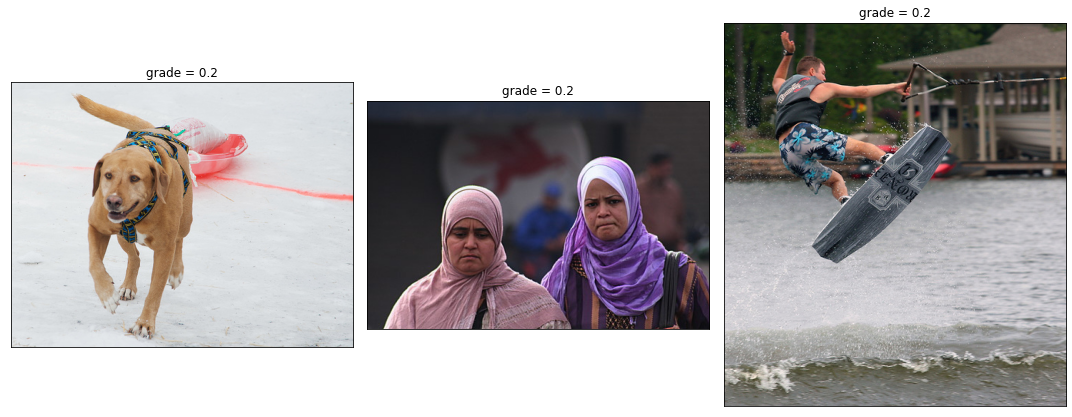

A man on an orange bike .


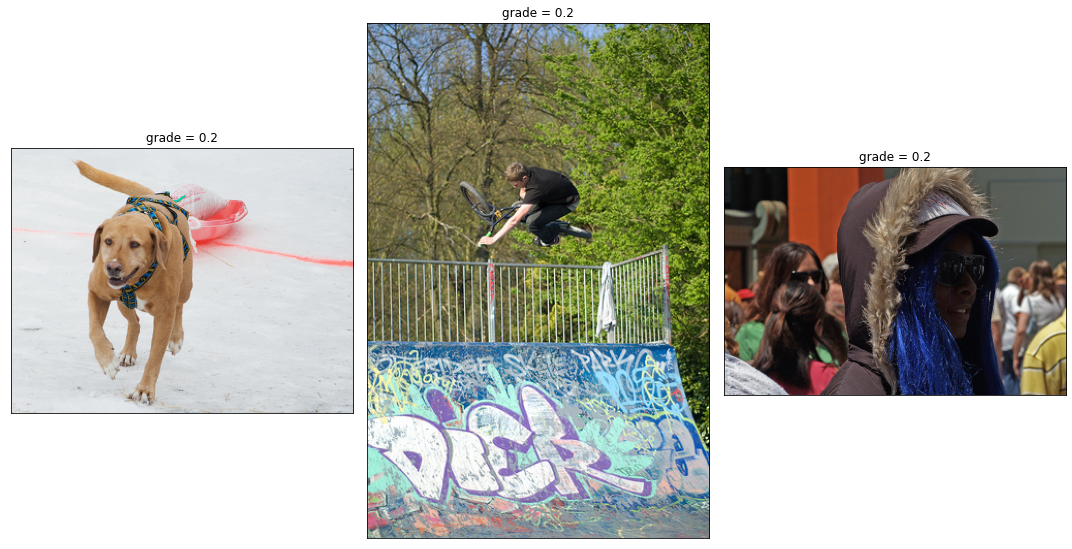

A tennis player in a blue shirt celebrates his match .


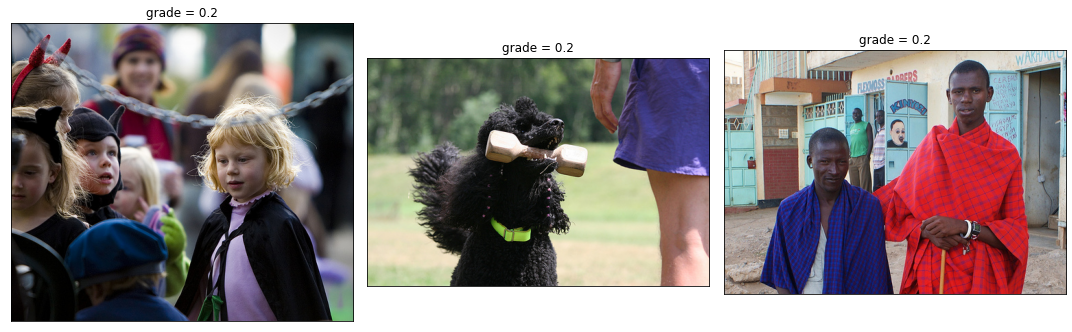

A red high speed racing boat skips across the water .


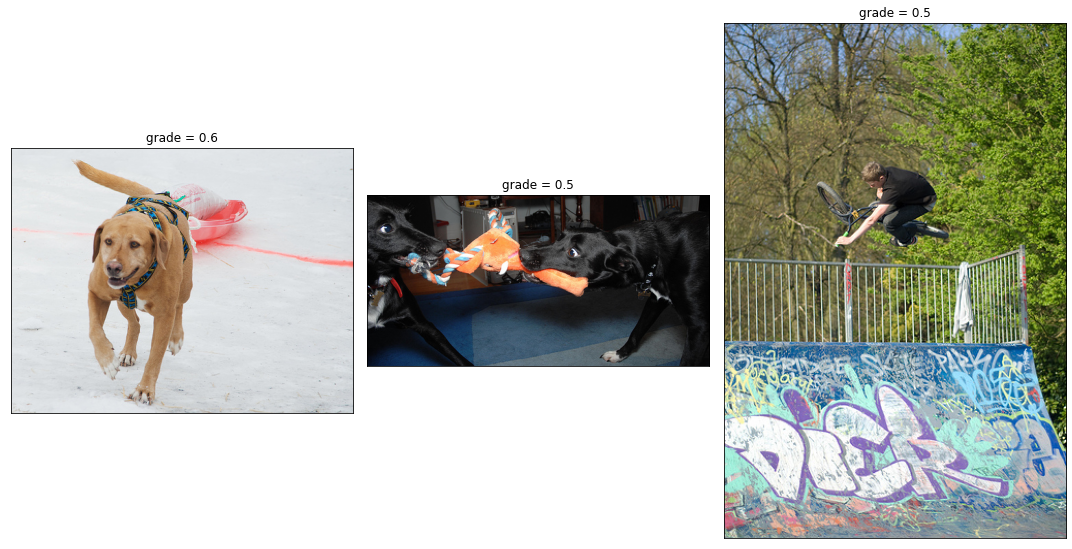

A snowboarder in a red jacket slides down a snowy mountain .


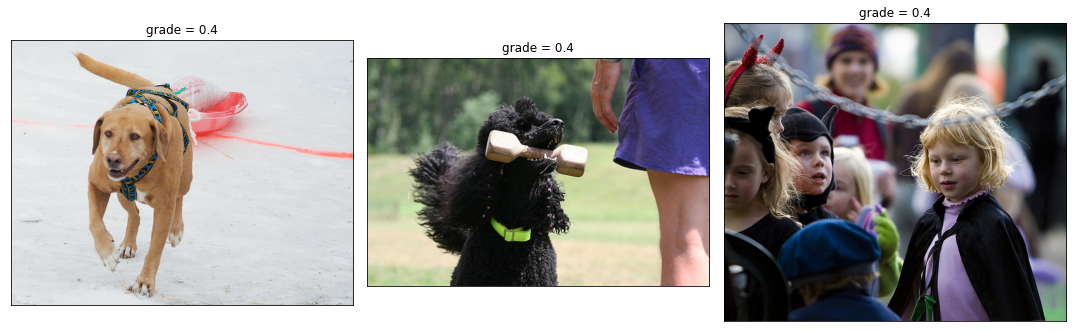

A large crowd of girls are all wearing green skirts and white tank tops .


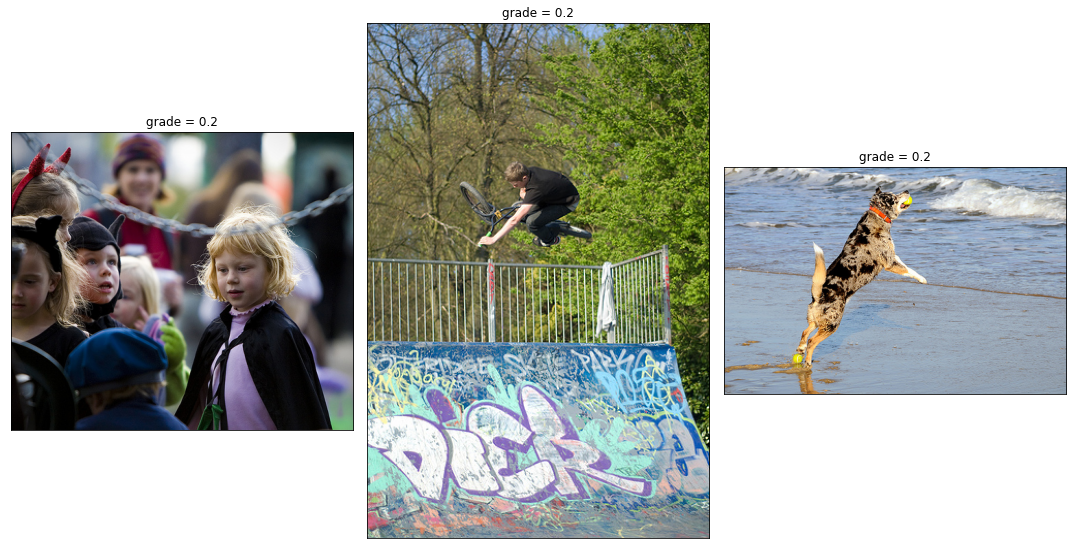

A baby girl playing at a park .


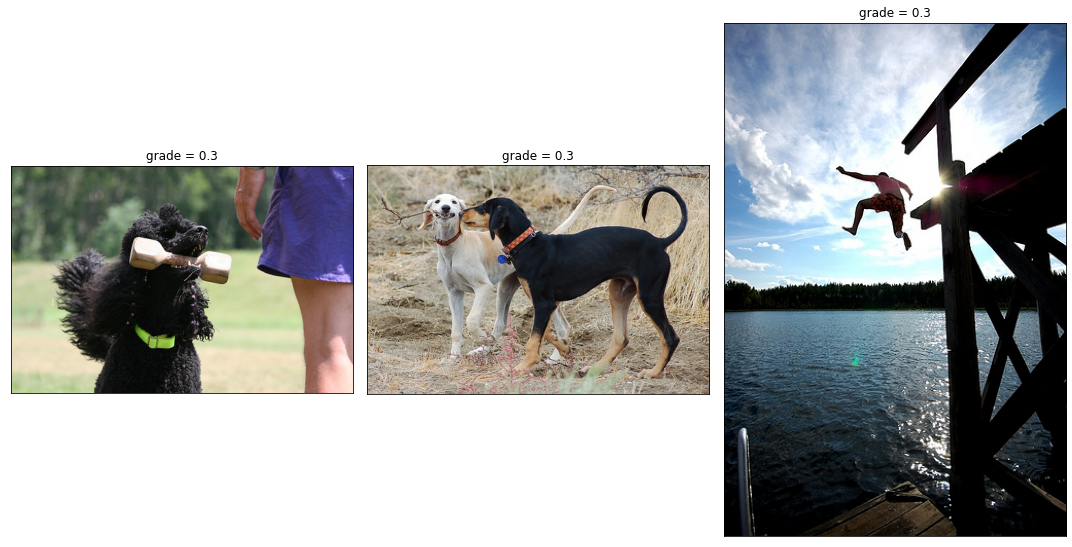

An Asian woman is taking a photograph outside a white columned building .


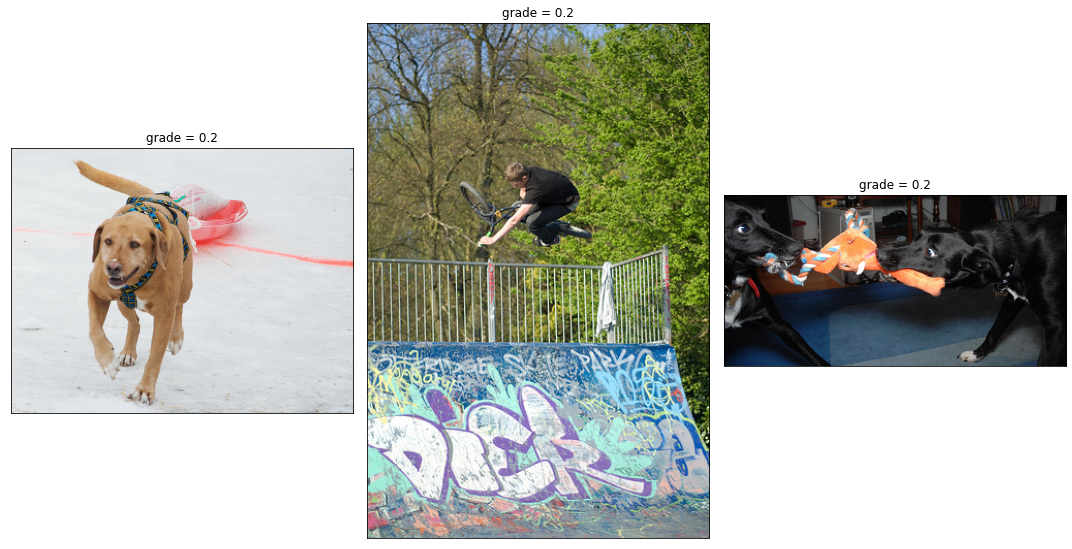

A woman wearing a red coat begins to take a picture .


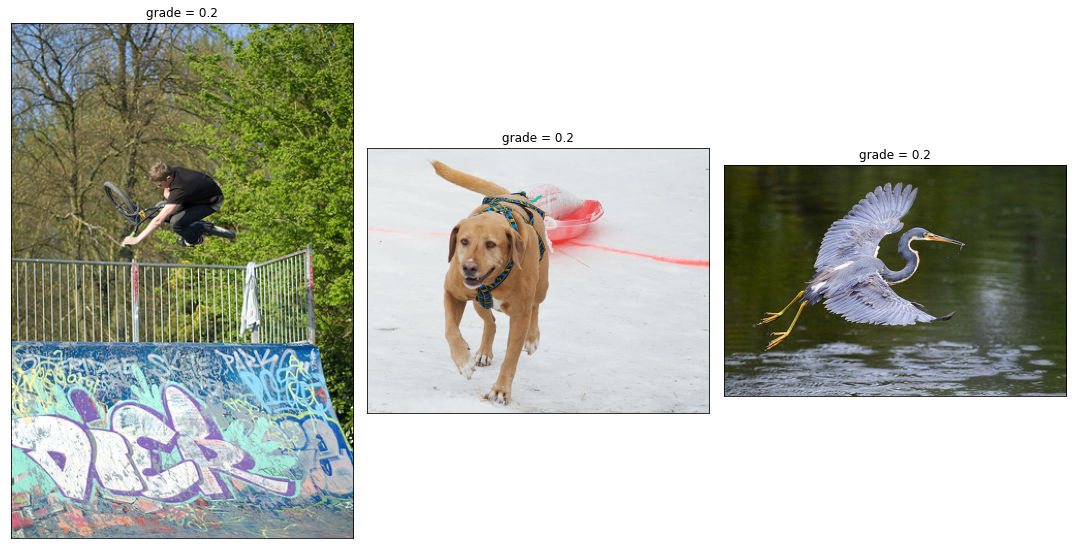

Middle school aged kids are showing their school spirit at a pep ralley .


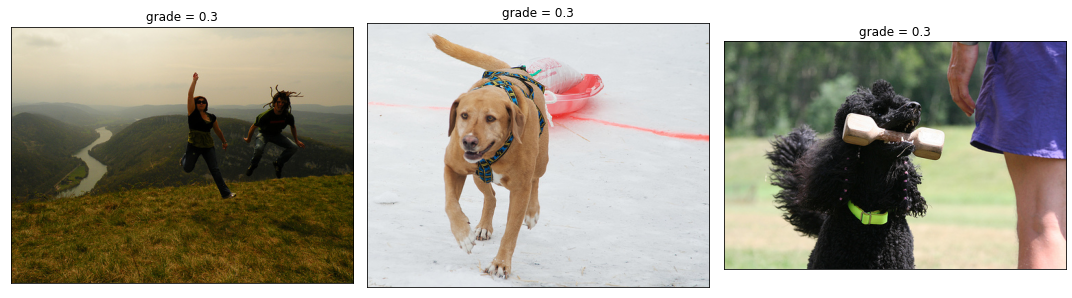

In [42]:
for _, row in df_test_queries.iterrows():
    print(row["query_text"])
    fig = plt.figure(figsize=(15,10))
    for img_name, grade,  i in zip(row["searched_image"], row["image_grade"], range(NUM_IMGS)):
        fig.add_subplot(1, NUM_IMGS, i+1)
        plt.imshow(Image.open(TEST_IMAGES + img_name).convert("RGB"))
        plt.xticks([])
        plt.yticks([])
        plt.title(f"grade = {grade:.1f}")
        plt.tight_layout()
    plt.show()


Можно видеть, что с помощью полносвязной нейронной сети удается отыскать изображения, частично соответствующие описанию, в отличие от линейной регрессии, когда на любой запрос выдаются одни и те же изображения. Интересно отметить, что величина RMSE при использовании рассмотренных моделей получается одинаковой. Можно заметить, что есть изображение (собака на белом фоне), которое модель соотносит с некоторыми запросами, опираясь на упоминание в нем цвета (красный, оранжевый) и не учитывает остальные данные в описании. По-видимому, подход, рассмотренный в работе, позволяет находить связь между запросом и изображением по некоторым крупным признакам, например, цвет, человек или скопление людей и плохо учитывает нюансы запросов. Возможно, что эту ситуации можно исправить введя определенную форму запросов, в которых признаки будут описываться более четко и однообразно.